In [ ]:
import os
import pandas as pd

# Speaker → Severity Mapping (as per Table 1)
speaker_severity_map = {
    "F02": "MEDIUM",
    "F03": "HIGH",
    "F04": "LOW",
    "F05": "VERY LOW",
    "M01": "HIGH",
    "M04": "HIGH",
    "M05": "LOW",
    "M07": "MEDIUM",
    "M08": "VERY LOW",
    "M09": "VERY LOW",
    "M10": "VERY LOW",
    "M11": "LOW",
    "M12": "HIGH",
    "M14": "VERY LOW",
    "M16": "MEDIUM"
}

# Path to dataset (Change this to your actual path)
dataset_path = "/kaggle/input/dysarthria-data/noisereduced-uaspeech"

# List to store extracted metadata
data = []

# Iterate through each speaker folder
for speaker_folder in os.listdir(dataset_path):
    speaker_path = os.path.join(dataset_path, speaker_folder)

    # Ensure it's a valid directory
    if not os.path.isdir(speaker_path):
        continue

    # Identify severity based on speaker ID
    severity_label = speaker_severity_map.get(speaker_folder, None)
    
    if severity_label is None:
        print(f"⚠ Warning: '{speaker_folder}' not found in speaker_severity_map. Skipping...")
        continue
    
    # Process all .wav files inside the speaker's folder
    for file_name in os.listdir(speaker_path):
        if file_name.lower().endswith(".wav"):
            file_path = os.path.join(speaker_path, file_name)
            data.append((file_path, speaker_folder, severity_label))

# Convert extracted metadata into a DataFrame
df = pd.DataFrame(data, columns=["file_path", "speaker", "severity"])

# Save metadata as CSV (for reference & further processing)
df.to_csv("uaspeech_metadata.csv", index=False)

# Print summary
print(f"✅ Successfully processed {len(df)} audio files.")
print(df.head())

In [ ]:
!pip install librosa numpy pandas tqdm matplotlib scikit-learn tensorflow -q

In [ ]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define parameters
SAMPLE_RATE = 44100  # Standard for speech processing
N_MELS = 128         # Number of mel bands
N_FFT = 400          # FFT window size
HOP_LENGTH = 160     # Hop length for frame shifting
T_MAX = 128          # Fixed time steps for all spectrograms

# Output directory for spectrograms
spectrogram_folder = "spectrograms_npy"
os.makedirs(spectrogram_folder, exist_ok=True)

# Function to convert audio to mel spectrogram
def process_audio(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=25)

        # Convert to mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)

        # Convert to log scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# Process all audio files
for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]
    mel_spec = process_audio(file_path)

    if mel_spec is not None:
        # Pad or truncate spectrogram to fixed size
        if mel_spec.shape[1] < T_MAX:
            pad_width = T_MAX - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode="constant")
        else:
            mel_spec = mel_spec[:, :T_MAX]

        # Save as .npy file
        np.save(os.path.join(spectrogram_folder, f"{idx}.npy"), mel_spec)

print("✅ All spectrograms saved as .npy files.")


# Verify one sample
example_spec = np.load(os.path.join(spectrogram_folder, "0.npy"))
plt.figure(figsize=(10, 4))
librosa.display.specshow(example_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Example Mel Spectrogram")
plt.show()

In [ ]:
import shutil

# Define the folder to zip and the output zip file name
folder_to_zip = "/kaggle/working/spectrograms_npy"  # Change this to your folder
output_zip = "/kaggle/working/spectrograms_npy.zip"

# Zip the folder
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_to_zip)

print(f"Zipped folder saved as: {output_zip}")

In [1]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import pandas as pd
import os

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

spectrogram_folder = "/kaggle/input/rescnn-input/1/spectrograms_npy"

# Reload dataset metadata
df = pd.read_csv("/kaggle/input/rescnn-input/1/uaspeech_metadata.csv")

severity_mapping = {"VERY LOW": 0, "LOW": 1, "MEDIUM": 2, "HIGH": 3}
df["severity"] = df["severity"].map(severity_mapping)

# Function to load .npy spectrogram
def load_spectrogram(idx):
    file_path = os.path.join(spectrogram_folder, f"{idx}.npy")
    return np.load(file_path) if os.path.exists(file_path) else None

# Load spectrograms and labels
X, y = [], []
for idx, row in df.iterrows():
    spec = load_spectrogram(idx)
    if spec is not None:
        X.append(spec)
        y.append(row["severity"])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for model input (add channel dimension)
X = np.expand_dims(X, axis=-1)  # Shape: (samples, mel, time, channels)

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

✅ Training Samples: 58940, Testing Samples: 14735


In [4]:
# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

✅ Training Samples: 58940, Testing Samples: 14735


In [5]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)  # Shape: (num_samples, 4)
y_test = to_categorical(y_test, num_classes=4)    # Shape: (num_samples, 4)

In [6]:
num_samples = y_train.shape[0]  # Get number of samples
# y_train_aux =/ to_categorical(np.random.randint(0, 4, num_samples), num_classes=4)
# y_test_aux = to_categorical(np.random.randint(0, 4, y_test.shape[0]), num_classes=4)

In [7]:
print(y_train.shape)#, y_train_aux.shape)
print(y_train[:5])  # Check if it's one-hot or integer labels

(58940, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [8]:
print(df.dtypes)

file_path    object
speaker      object
severity      int64
dtype: object


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Model Parameters
INPUT_SHAPE = (128, 128, 1)  # Mel spectrogram shape (Mel bands, Time steps, Channels)
NUM_CLASSES = 4  # Dysarthria severity levels: VERY LOW, LOW, MEDIUM, HIGH
AUX_CLASSES = 4  # Example auxiliary task (e.g., speaker or phoneme classification)

# CQTCNN Feature Extraction
def cqt_cnn_block(x):
    x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return x

# Residual Block with Projection Shortcut
def residual_block(x, filters):
    shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)  # Ensure matching dimensions
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Multi-Head Attention Block
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    
    def call(self, inputs):
        return self.mha(inputs, inputs)

# Model Architecture with Multi-Task Learning
def build_model():
    inputs = Input(shape=INPUT_SHAPE)
    
    # CQTCNN Feature Extraction
    x = cqt_cnn_block(inputs)
    
    # ResCNN Blocks
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten before Attention
    x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
    
    # Multi-Head Attention
    x = MultiHeadSelfAttention(num_heads=4, embed_dim=256)(x)
    
    # Global Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Output for Dysarthria Severity Classification
    severity_output = layers.Dense(NUM_CLASSES, activation="softmax", name="severity_output")(x)
    
    # Auxiliary Output for Speaker/Phoneme Classificatio
    
    # Create Model
    model = Model(inputs, outputs=[severity_output])
    return model

# Build Model
model = build_model()
model.compile(
    loss={
        "severity_output": "categorical_crossentropy",
        # "aux_output": "categorical_crossentropy"
    },
    metrics={
        "severity_output": ["accuracy"],
        # "aux_output": ["accuracy"]
    },
    optimizer="adam"
)




# Print Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │          8,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 128)    │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 128)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 2,225,284 (8.49 MB)

 Trainable params: 2,222,788 (8.48 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [17]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,  # Stop training if val_loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore model weights from the best epoch
)

history = model.fit(
    X_train, 
    {"severity_output": y_train},  # "aux_output": y_train_aux},  # Provide labels for both outputs if needed
    validation_data=(X_test, {"severity_output": y_test}),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add EarlyStopping callback
)

Epoch 1/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.9818 - loss: 0.0488 - val_accuracy: 0.9496 - val_loss: 0.1468
Epoch 2/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.9854 - loss: 0.0433 - val_accuracy: 0.8523 - val_loss: 1.0553
Epoch 3/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.9873 - loss: 0.0374 - val_accuracy: 0.9576 - val_loss: 0.1307
Epoch 4/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.9877 - loss: 0.0359 - val_accuracy: 0.9570 - val_loss: 0.1403
Epoch 5/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.9876 - loss: 0.0346 - val_accuracy: 0.9458 - val_loss: 0.1869
Epoch 6/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.9853 - loss: 0.0406 - val_accuracy: 0.9249 - val_loss: 0.2842
Epoch 7/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.9897 - loss: 0.0279 - val_accuracy: 0.9080 - val_loss: 0.5022
Epoch 8/50
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.9894 -

In [15]:
model.save("dysarthria_severity_model.h5")  # Saves architecture, weights, and optimizer state

In [ ]:
print("y_train keys:", y_train.keys())  # Should contain "severity_output" and "aux_output"
print("y_train['severity_output'] shape:", y_train["severity_output"].shape)  # Should be (num_samples, 4)
print("y_train['aux_output'] shape:", y_train["aux_output"].shape)  # Should be (num_samples, 10)

In [18]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9609 - loss: 0.1192
✅ Test Accuracy: 95.76%


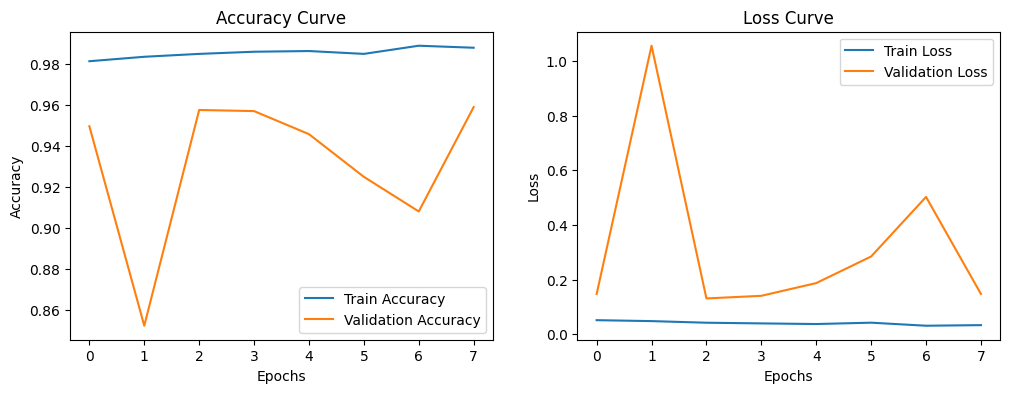

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axes[0].plot(history.history["accuracy"], label="Train Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Loss Plot
    axes[1].plot(history.history["loss"], label="Train Loss")
    axes[1].plot(history.history["val_loss"], label="Validation Loss")
    axes[1].set_title("Loss Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

# Call function
plot_training_history(history)